In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import Point
import matplotlib.pyplot as plt
from datetime import datetime

## Fetch shape and demograhpic data at municipality level & merge them

In [3]:
# Load geodata
gdf = gpd.read_file("../raw/sprint_2025/shape_muni.gpkg", layer="shape_muni")

# Load demography
demographics = pd.read_csv('../raw/sprint_2025/datasus_population_2001_2024.csv')

# Choose year or average
year = 2010
if year:
    demographics = demographics[demographics['year']==year][['geocode','population']]
else:
    demographics = demographics.groupby(by='geocode')['population'].mean()

# Merge demography with the geodata
gdf = gdf.merge(demographics, on="geocode")

## Build a state adjacency matrix

In [ ]:
# Step 1: Clean invalid geometries
gdf = gdf[gdf.geometry.notnull()].copy()
gdf["geometry"] = gdf["geometry"].buffer(0)

# Step 2: Dissolve municipalities to state-level geometries
states_gdf = gdf.dissolve(by="uf", as_index=False)
states_gdf = states_gdf.reset_index(drop=True)

# Step 3: Ensure "uf" column is clean and sorted
states_gdf["uf"] = states_gdf["uf"].astype(str).str.strip()
states_gdf = states_gdf.sort_values("uf").reset_index(drop=True)
uf_list = states_gdf["uf"].tolist()

# Step 4: Build spatial index and adjacency dictionary
sindex = states_gdf.sindex
adjacency = {uf: set() for uf in uf_list}

for i, row in states_gdf.iterrows():
    geom_i = row.geometry
    uf_i = row["uf"]
    possible_matches_index = list(sindex.intersection(geom_i.bounds))
    
    for j in possible_matches_index:
        if i == j:
            continue
        geom_j = states_gdf.loc[j, "geometry"]
        uf_j = states_gdf.loc[j, "uf"]
        
        # Use intersects instead of touches for robustness
        if geom_i.intersects(geom_j):
            adjacency[uf_i].add(uf_j)
            adjacency[uf_j].add(uf_i)  # symmetric

# Step 5: Convert to binary adjacency matrix
adj_matrix = pd.DataFrame(0, index=uf_list, columns=uf_list)

for uf in uf_list:
    for neighbor in adjacency[uf]:
        adj_matrix.loc[uf, neighbor] = 1

# Save in a .csv
adj_matrix.to_csv('../interim/adjacency_matrix.csv')


## Population density of states

In [3]:
# 1. Ensure your GeoDataFrame has the correct CRS (projected, not geographic)
# For area calculations, use a projected CRS in meters, such as Brazil's SIRGAS 2000 / Brazil Mercator
gdf = gdf.to_crs("EPSG:5880")  # or another appropriate projected CRS

# 2. Compute area of each municipality in square kilometers
gdf["area_km2"] = gdf.geometry.area / 1e6  # Convert m² to km²

# 3. Group by state to sum population and area
state_df = gdf.groupby("uf").agg({
    "population": "sum",
    "area_km2": "sum"
}).reset_index()

# 4. Compute population density: people per km²
state_df["population_density"] = state_df["population"] / state_df["area_km2"]

# 5. Omit area
state_df = state_df[['uf', 'population', 'population_density']]

## Population urbanicity of states

In [4]:
# Use gini population coefficient
def gini(array):
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

# Assure appropriate projection
gdf = gdf.to_crs("EPSG:5880")
# compute gini values
gini_values = (
    gdf.groupby('uf')
    .apply(lambda x: gini(x['population'].values))
    .rename("gini_population")
    .reset_index()
)
# add to state_df
state_df['gini_population'] = gini_values['gini_population']

/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_20715/3291030740.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: gini(x['population'].values))


## Average hospital beds per state

In [ ]:
# Load hospital bed data
hospital_beds = pd.read_csv('../interim/BR_hospital-beds-per-capita_2005-2023.csv', index_col=0)
# Average over all time
hospital_beds['date'] = pd.to_datetime(hospital_beds['date'])
hospital_beds.loc[((datetime(2005,1,1) < hospital_beds['date']) & (hospital_beds['date'] < datetime(2024,1,1)))]
hospital_beds = hospital_beds[['date', 'UF', 'beds_per_1000']]
# Add to state df
state_df['hospital_beds_per_1000'] = hospital_beds.groupby(by='UF')['beds_per_1000'].mean().values

## Climate data

In [ ]:
# Get climate data
climate_df = pd.read_csv('../raw/sprint_2025/climate.csv', index_col=0)
# Get mapping geocode --> region
zip2uf_map = gdf[['uf', 'geocode']].drop_duplicates().set_index('geocode')['uf'].to_dict()
climate_df['uf'] = climate_df['geocode'].map(zip2uf_map)
# merge
state_df['rel_humid_med'] = climate_df.groupby(by='uf')['rel_humid_med'].mean().values
state_df['precip_med'] = climate_df.groupby(by='uf')['precip_med'].mean().values
state_df['temp_med'] = climate_df.groupby(by='uf')['temp_med'].mean().values

## Demographically-weighted distance matrix

In [ ]:
# Assure appropriate projection
gdf = gdf.to_crs("EPSG:5880")

# Calculate centroids of municipalities
gdf['centroid'] = gdf.geometry.centroid

# Helper function
def weighted_centroid(group):
    # Get x and y from centroid
    x = group['centroid'].x
    y = group['centroid'].y
    weights = group['population']
    
    # Weighted average
    x_bar = (x * weights).sum() / weights.sum()
    y_bar = (y * weights).sum() / weights.sum()
    
    return Point(x_bar, y_bar)

# Group by UF and calculate weighted centroids
weighted_centroids = gdf.groupby('uf').apply(weighted_centroid).reset_index()
weighted_centroids.columns = ['uf', 'geometry']
uf_centroids_gdf = gpd.GeoDataFrame(weighted_centroids, geometry='geometry', crs=gdf.crs)

# Create empty DataFrame
uf_codes = uf_centroids_gdf['uf'].tolist()
dist_matrix = pd.DataFrame(index=uf_codes, columns=uf_codes, dtype=float)

# Fill with distances in kilometers
for i, row_i in uf_centroids_gdf.iterrows():
    for j, row_j in uf_centroids_gdf.iterrows():
        dist = row_i.geometry.distance(row_j.geometry) / 1000  # meters to km
        dist_matrix.loc[row_i['uf'], row_j['uf']] = dist

# Save the distance matrix to a csv file
dist_matrix.to_csv('../interim/weighted_distance_matrix.csv')

/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_20715/616721399.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_centroids = gdf.groupby('uf').apply(weighted_centroid).reset_index()


## Adjacency matrix

In [10]:
gdf

,geocode,geocode_name,uf,uf_code,geometry,population,area_km2,centroid
0,1100015,Alta Floresta D'oeste,RO,11,"MULTIPOLYGON (((4132778.992 8645407.526, 41326...",25094,7138.716308,POINT (4100634.631 8606925.933)
1,1100023,Ariquemes,RO,11,"MULTIPOLYGON (((3993766.084 8864583.959, 39933...",91527,4480.712037,POINT (4017885.013 8886190.022)
2,1100031,Cabixi,RO,11,"MULTIPOLYGON (((4273635.423 8516566.721, 42732...",6536,1322.751714,POINT (4281162.015 8500040.919)
3,1100049,Cacoal,RO,11,"MULTIPOLYGON (((4198507.804 8717352.861, 41986...",79624,3821.895183,POINT (4200411.422 8740190.486)
4,1100056,Cerejeiras,RO,11,"MULTIPOLYGON (((4260103.584 8539950.69, 426022...",17440,2804.547801,POINT (4213036.835 8528368.642)
...,...,...,...,...,...,...,...,...
5565,5222005,Vianópolis,GO,52,"MULTIPOLYGON (((5606404.749 8128508.774, 56071...",12841,958.335643,POINT (5592489.969 8132097.606)
5566,5222054,Vicentinópolis,GO,52,"MULTIPOLYGON (((5452598.311 8032487.357, 54524...",7483,735.480632,POINT (5437746.374 8034798.957)
5567,5222203,Vila Boa,GO,52,"MULTIPOLYGON (((5744412.734 8322394.689, 57444...",4729,1059.822670,POINT (5746032.865 8330089.724)
5568,5222302,Vila Propício,GO,52,"MULTIPOLYGON (((5581246.451 8298812.356, 55809...",5261,2189.990546,POINT (5557057.129 8304536.825)


## Population-weighted latitude of state

In [8]:
# 1. Ensure GeoDataFrame has a geographic CRS (WGS84) for lat/lon
uf_centroids_gdf = uf_centroids_gdf.to_crs("EPSG:4326")  # WGS84
# 2. Compute weighted latitude
state_df['population_weighted_latitude'] = uf_centroids_gdf['geometry'].y

In [ ]:
# Save state_df
state_df.to_csv('../interim/state_covariates.csv', index=False)

## Visualise population-weighted centroid versus non-weighted centroid

/var/folders/ny/j5ym9thj7l34rykpfr__k_540000gr/T/ipykernel_68421/3399685045.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uf_weighted_centroids = gdf.groupby('uf').apply(weighted_centroid).reset_index()


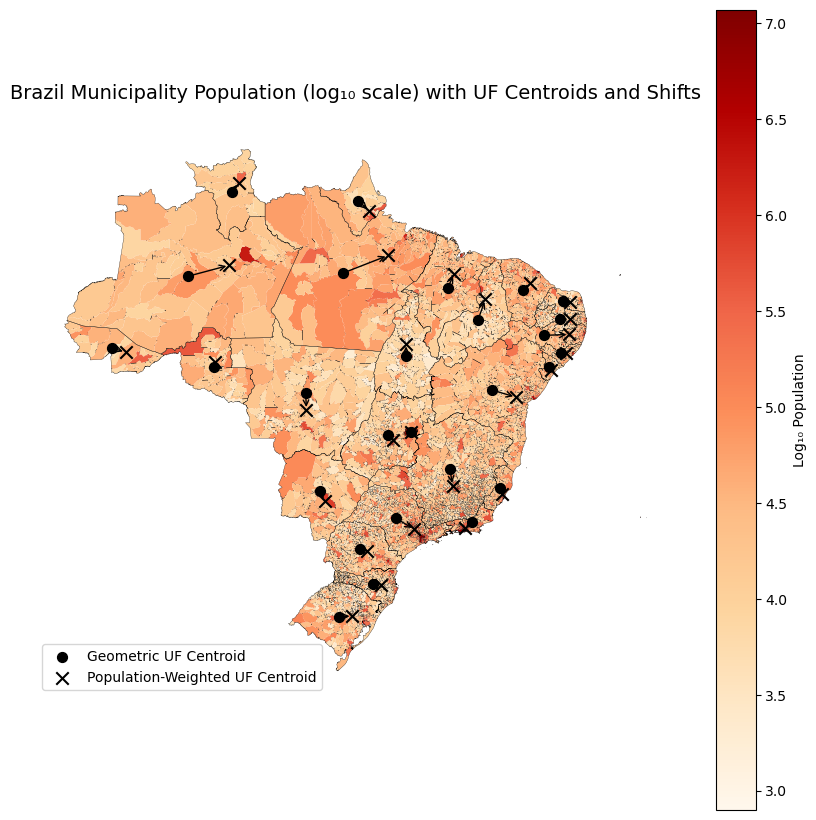

In [ ]:
# Ensure proper projection
gdf = gdf.to_crs(epsg=5880)  # Brazil Albers Equal Area

# Compute municipality centroids for weighting
gdf['centroid'] = gdf.geometry.centroid

# Log-transformed population (avoid log(0) issues)
gdf['log_population'] = np.log10(gdf['population'].replace(0, np.nan))

# Weighted centroid function
def weighted_centroid(group):
    x = group['centroid'].x
    y = group['centroid'].y
    weights = group['population']
    x_bar = (x * weights).sum() / weights.sum()
    y_bar = (y * weights).sum() / weights.sum()
    return Point(x_bar, y_bar)

# Calculate centroids
uf_weighted_centroids = gdf.groupby('uf').apply(weighted_centroid).reset_index()
uf_weighted_centroids.columns = ['uf', 'geometry']
uf_weighted_centroids = gpd.GeoDataFrame(uf_weighted_centroids, geometry='geometry', crs=gdf.crs)

# Geometric (pure) centroids via dissolve
uf_geom = gdf.dissolve(by='uf')
uf_geom['geometry'] = uf_geom.geometry.centroid
uf_geom_centroids = uf_geom.reset_index()

# Get dissolved UF borders for plotting
uf_borders = gdf.dissolve(by='uf')  # original geometry preserved here

# Plotting
fig, ax = plt.subplots(figsize=(8.3, 8.3))

# 1. Plot municipalities shaded by log population
gdf.plot(column='log_population',
         cmap='OrRd',
         linewidth=0,
         edgecolor='black',
         ax=ax,
         legend=True,
         legend_kwds={'label': "Log₁₀ Population"})

# 2. Overlay state borders (thicker and darker)
uf_borders.boundary.plot(ax=ax, linewidth=0.2, edgecolor='black')

# 3. Plot geometric centroids
uf_geom_centroids.plot(ax=ax, color='black', marker='o', markersize=50, label='Geometric UF Centroid')

# 4. Plot population-weighted centroids
uf_weighted_centroids.plot(ax=ax, color='black', marker='x', markersize=80, label='Population-Weighted UF Centroid')

# 5. Draw arrows between centroids
for _, row in uf_geom_centroids.iterrows():
    uf = row['uf']
    pt_from = row['geometry']
    pt_to = uf_weighted_centroids.loc[uf_weighted_centroids['uf'] == uf, 'geometry'].values[0]
    
    ax.annotate('', xy=(pt_to.x, pt_to.y),
                     xytext=(pt_from.x, pt_from.y),
                     arrowprops=dict(arrowstyle="->", color='black', lw=1))

# 6. Legend and title
plt.title("Brazil Municipality Population (log₁₀ scale) with UF Centroids and Shifts", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('../interim/population_weighted_centroid.png', dpi=300)
plt.show()
